<a href="https://colab.research.google.com/github/pariscwang/vehicle-carbon-emission-prediction/blob/main/Fuel_Efficiency_Carbon_Emission_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Up

### Import Libraries


In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.api import OLS
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CO2 Emissions_Canada.csv')

#!pip install -q kaggle
#!pip install -q kaggle-cli

Mounted at /content/drive


### Check Data

In [3]:
# Check head.
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

This dataset has no missing values.

In [5]:
df.shape

(7385, 12)

### Column Names

In [6]:
# Rename columns for easy reference
renamed_columns = {
    'Make' : "make",
    'Model' : 'model',
    'Vehicle Class': 'vehicle_class',
    'Engine Size(L)': 'engine_size',
    'Cylinders': 'cylinders',
    'Transmission' : 'transmission',
    'Fuel Type': 'fuel_type',
    'Fuel Consumption City (L/100 km)': 'fuel_cons_city',
    'Fuel Consumption Hwy (L/100 km)': 'fuel_cons_hwy',
    'Fuel Consumption Comb (L/100 km)': 'fuel_cons_comb',
    'Fuel Consumption Comb (mpg)': 'mpgfuel_cons_comb',
    'CO2 Emissions(g/km)': 'co2' }
df.rename(renamed_columns, axis='columns', inplace=True)

In [7]:
df.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


### Feature Engineering

Transmission

A = Automatic

AM = Automated manual

AS = Automatic with select shift

AV = Continuously variable (automatic)

M = Manual

3 - 10 = Number of gears

In [8]:
# Group transmission by types (automatic, manual, auto-manual)
transmission_list = df['transmission'].unique()

In [9]:
transmission_list

array(['AS5', 'M6', 'AV7', 'AS6', 'AM6', 'A6', 'AM7', 'AV8', 'AS8', 'A7',
       'A8', 'M7', 'A4', 'M5', 'AV', 'A5', 'AS7', 'A9', 'AS9', 'AV6',
       'AS4', 'AM5', 'AM8', 'AM9', 'AS10', 'A10', 'AV10'], dtype=object)

In [10]:
def classify_transmission(row):
  if row['transmission'][0] == 'A':
    if row['transmission'][1] == 'M':
      return 'AM'

    else:
      return 'A'

  else:
    return 'M'

df['transmission_type'] = df.apply(classify_transmission, axis = 1)

In [11]:
df.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2,transmission_type
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,A
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221,M
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136,A
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,A
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,A


## Exploratory Data Analysis

### Unique Values

In [12]:
def get_unique_values(df):

    output = []

    for col in df.columns:

        # If the number of unique values in the column is less than or equal to 10
        if df.loc[:, col].nunique() <= 10:
            # Get the unique values in the column
            unique_values = df.loc[:, col].unique()
            # Append the column name, number of unique values, unique values, and data type to the output data
            output.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        else:
            # Otherwise, append only the column name, number of unique values, and data type to the output data
            output.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

    output_df = pd.DataFrame(output, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

    return output_df

get_unique_values(df)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,make,42,-,object
1,model,2053,-,object
2,vehicle_class,16,-,object
3,engine_size,51,-,float64
4,cylinders,8,"[4, 6, 12, 8, 10, 3, 5, 16]",int64
5,transmission,27,-,object
6,fuel_type,5,"[Z, D, X, E, N]",object
7,fuel_cons_city,211,-,float64
8,fuel_cons_hwy,143,-,float64
9,fuel_cons_comb,181,-,float64


### Summary Statistics

In [13]:
# Generate summary statistics.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
engine_size,7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
fuel_cons_city,7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
fuel_cons_hwy,7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
fuel_cons_comb,7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
mpgfuel_cons_comb,7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
co2,7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


### Correlation Analysis

In [14]:
df.corr()

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2
engine_size,1.000000,0.927653,0.831379,0.761526,0.817060,-0.757854,0.851145
cylinders,0.927653,1.000000,0.800702,0.715252,0.780534,-0.719321,0.832644
fuel_cons_city,0.831379,0.800702,1.000000,0.948180,0.993810,-0.927059,0.919592
fuel_cons_hwy,0.761526,0.715252,0.948180,1.000000,0.977299,-0.890638,0.883536
fuel_cons_comb,0.817060,0.780534,0.993810,0.977299,1.000000,-0.925576,0.918052
mpgfuel_cons_comb,-0.757854,-0.719321,-0.927059,-0.890638,-0.925576,1.000000,-0.907426
co2,0.851145,0.832644,0.919592,0.883536,0.918052,-0.907426,1.000000


<Axes: >

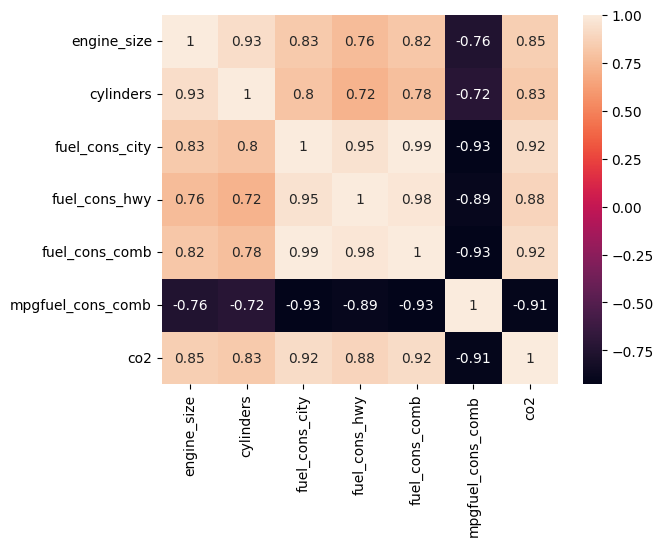

In [15]:
sns.heatmap(df.corr(), annot = True)

Note multicolinearity between features.

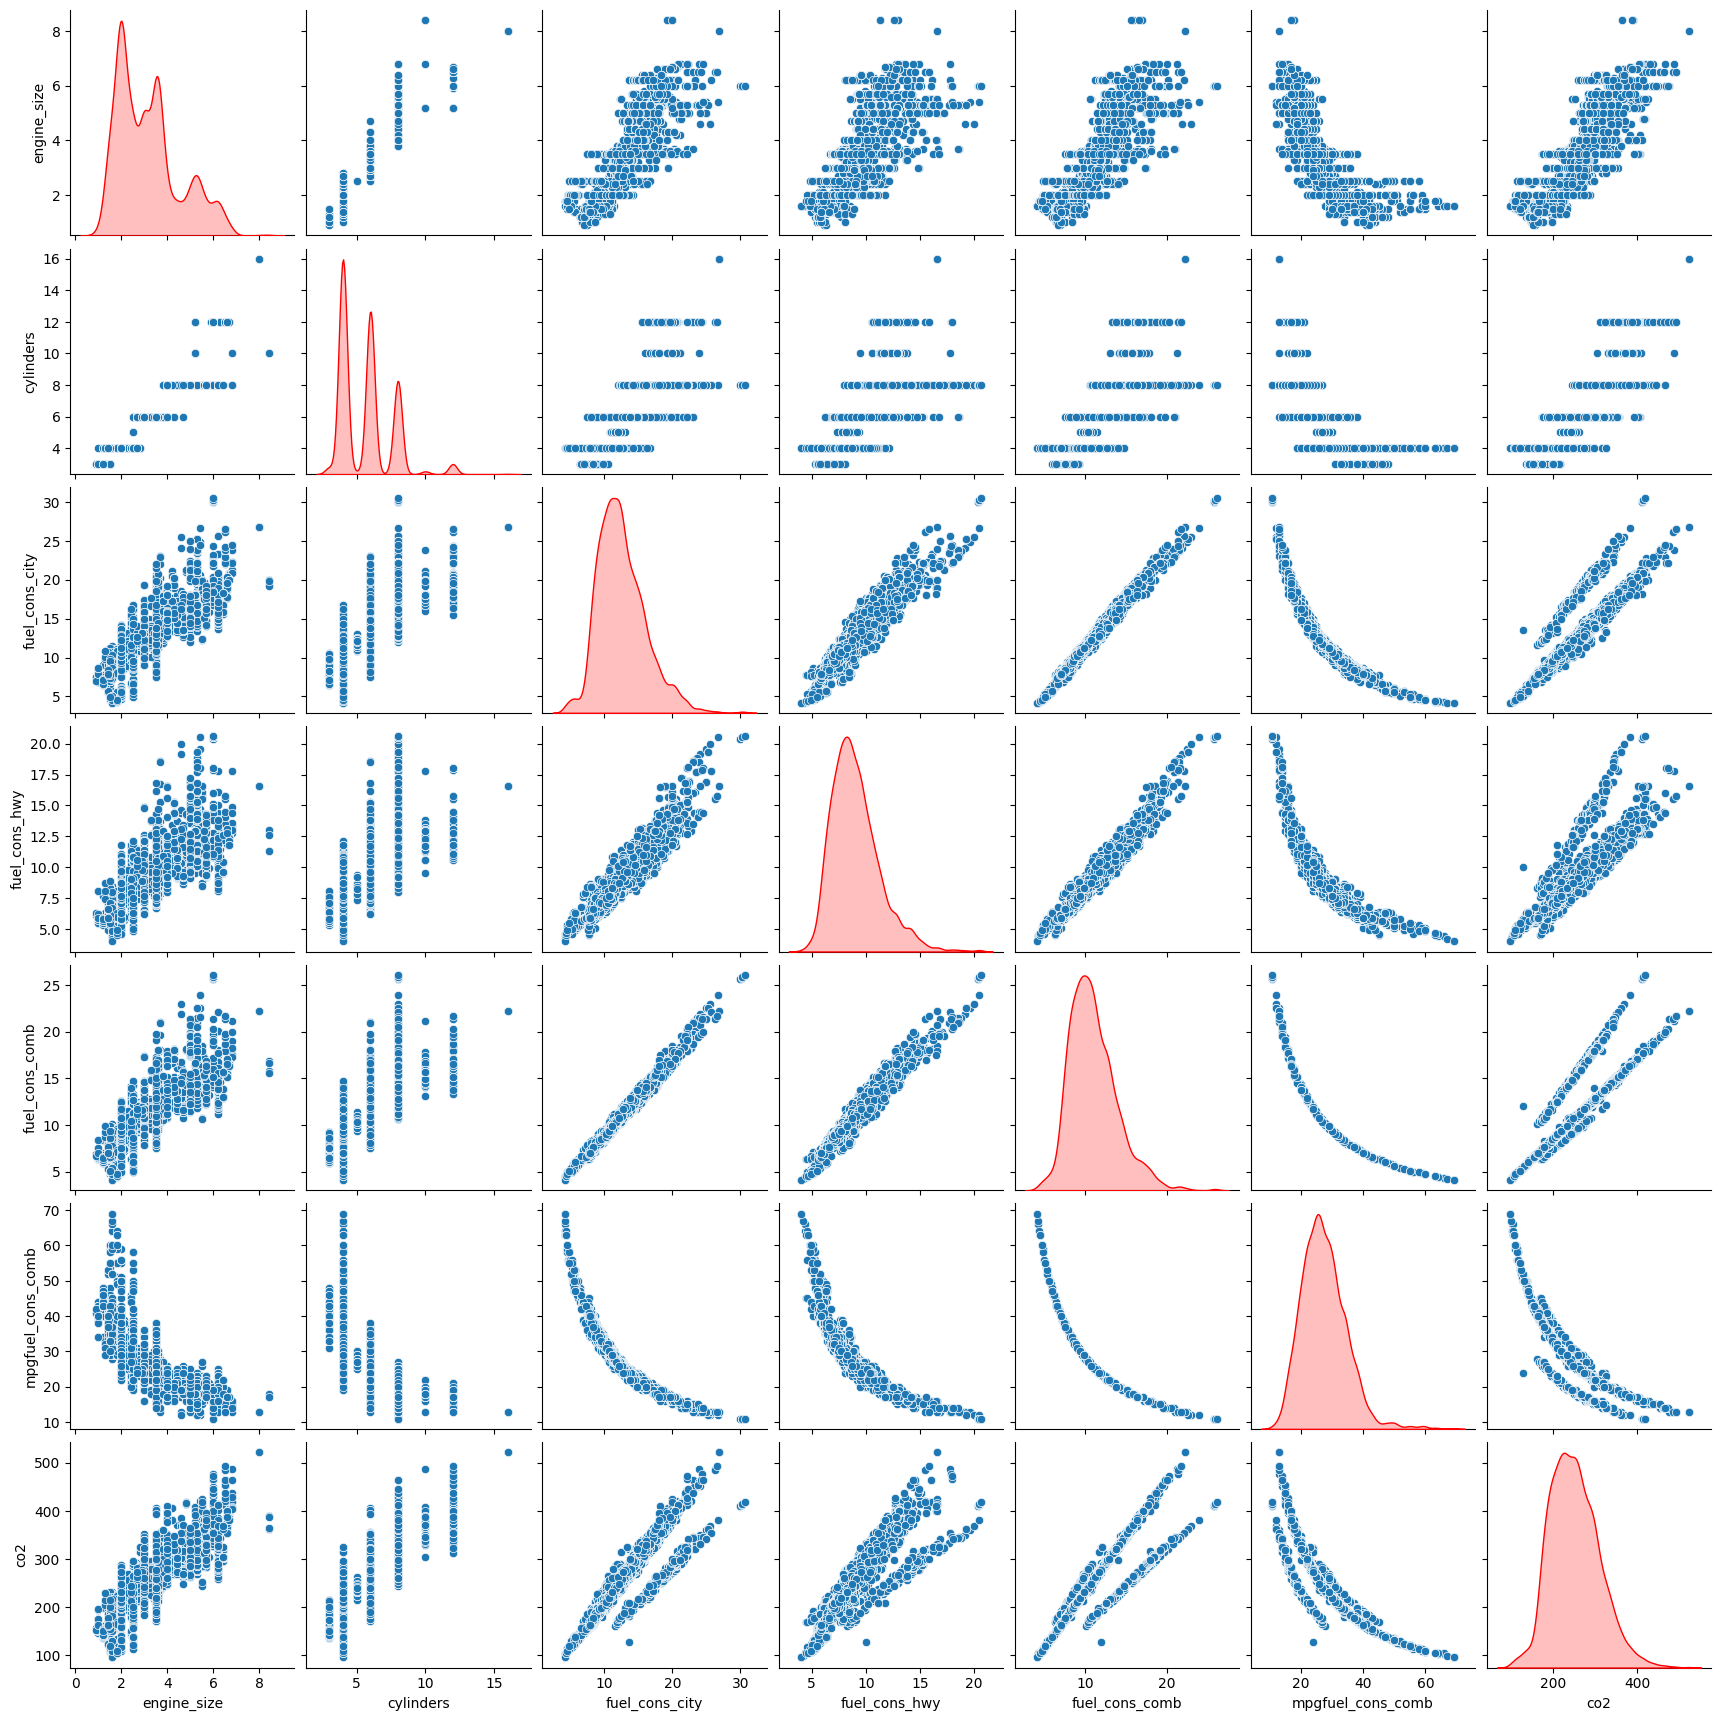

In [16]:
sns.pairplot(df,diag_kind = "kde",diag_kws={"color":"red"})

### Data Visualization



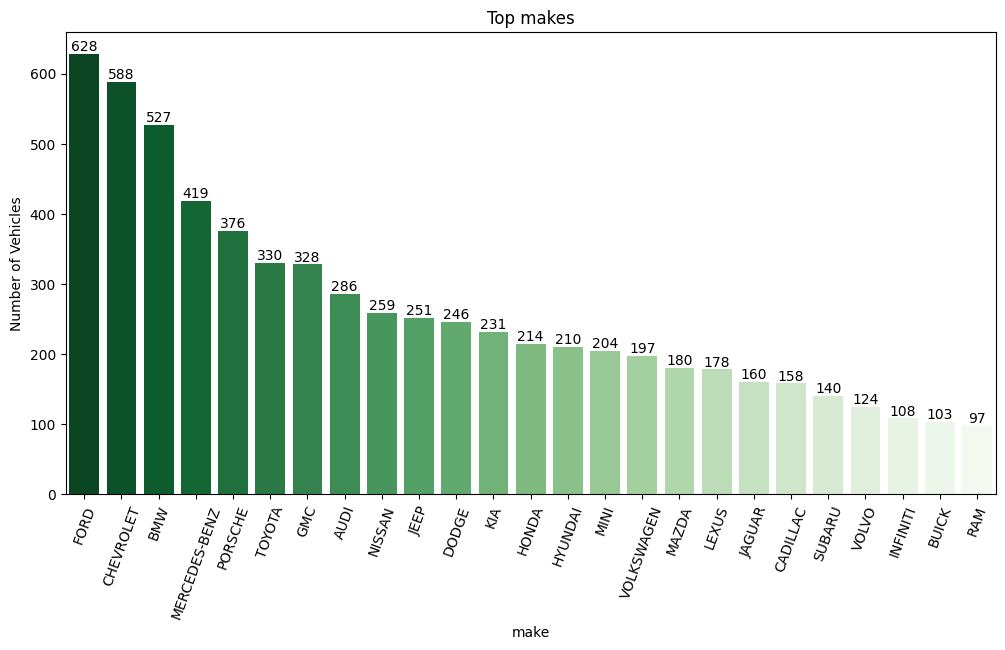

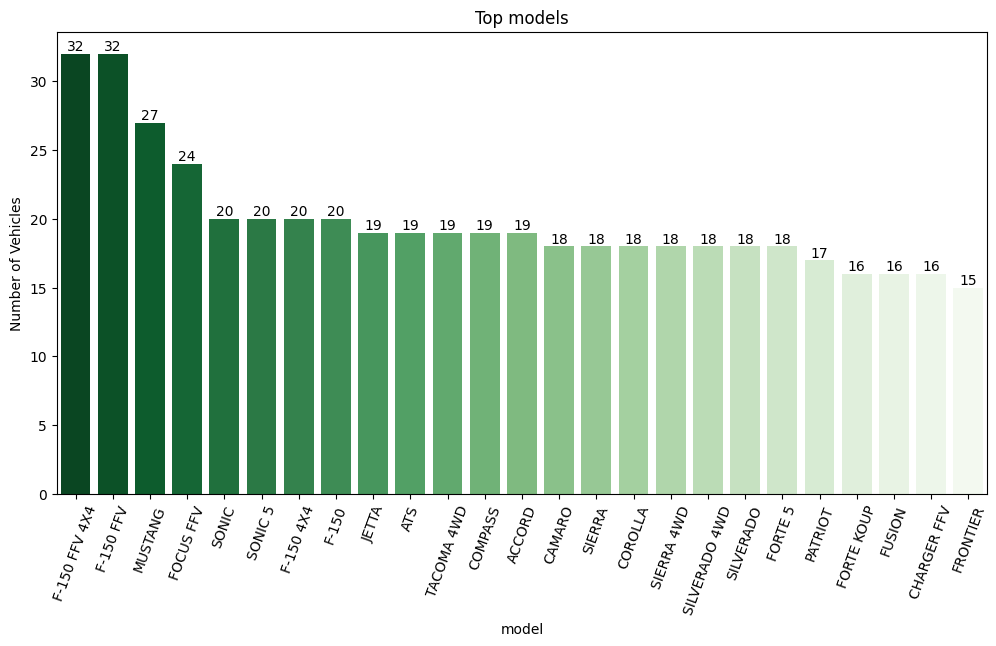

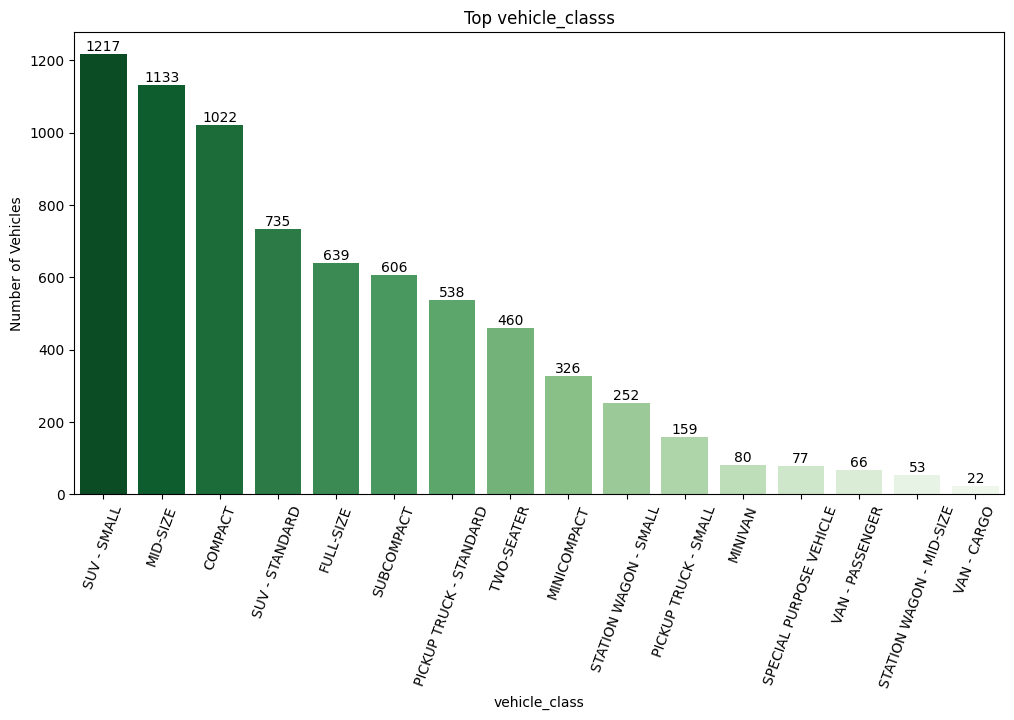

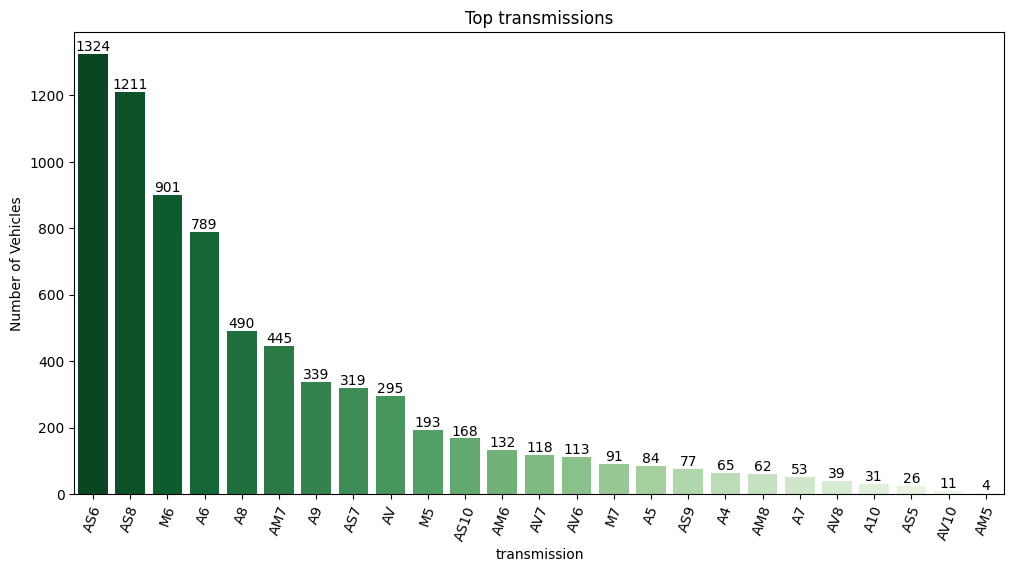

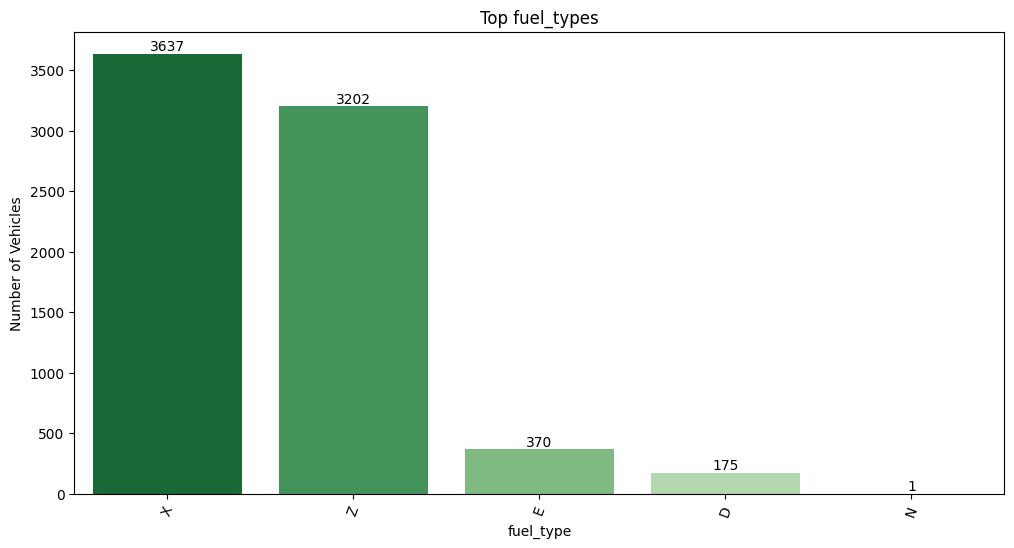

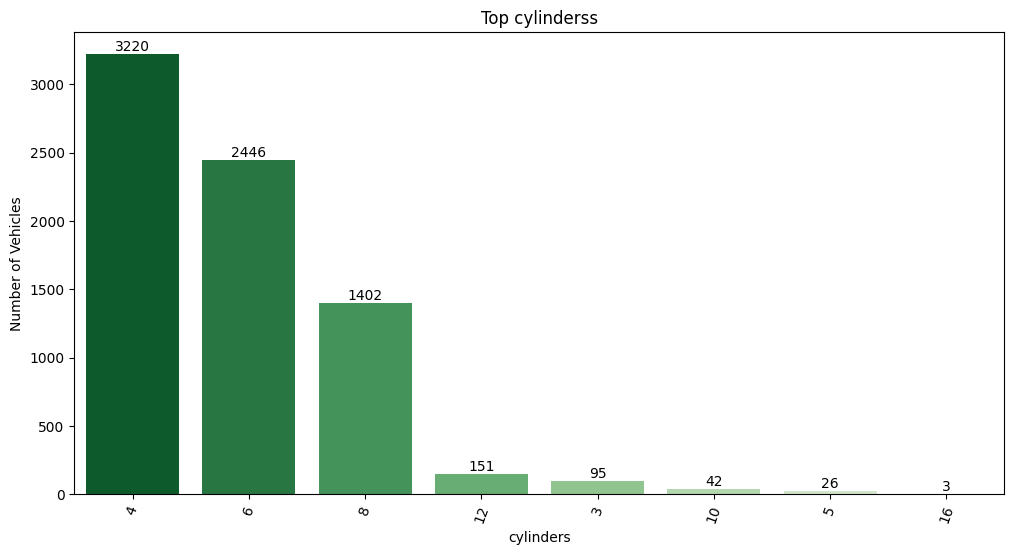

In [17]:
# Let's take a look at our data
  # Here, we are viewing cylinders as categorical data, since the number of cylinders represents a group.

for column in ['make', 'model', 'vehicle_class', 'transmission', 'fuel_type','cylinders']:
    df_column = df[column].value_counts().reset_index().rename(columns={'index': column, column: 'Count'})[0:25]
    df_column = df_column.sort_values(by='Count', ascending=False)
    df_column[column] = df_column[column].astype(str)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    pal = sns.color_palette("Greens_r", len(df_column))
    bars = sns.barplot(x=df_column[column], y=df_column['Count'], palette = pal, ax=ax)

    plt.xticks(rotation=70)
    plt.title(f'Top {column}s')
    plt.xlabel(column)
    plt.ylabel('Number of Vehicles')

    # Label each bar with its value count
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                bar.get_height(),
                f'{int(bar.get_height())}',
                ha='center', va='bottom',
                color='black')

    # Display the plot
    plt.show()

### Data Distribution


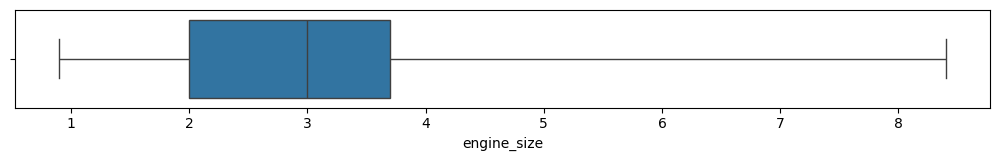

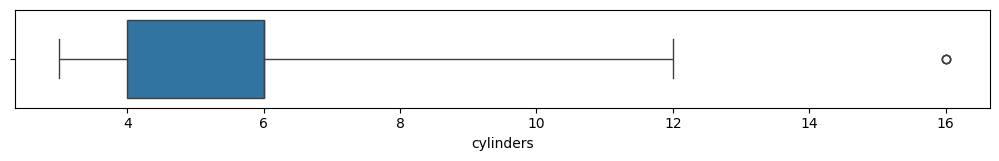

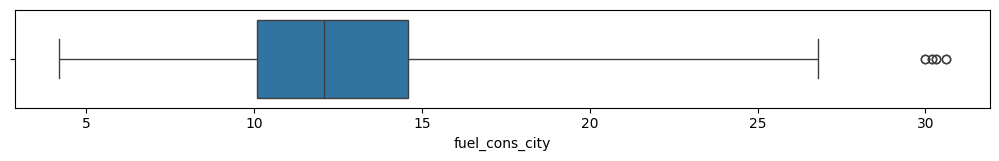

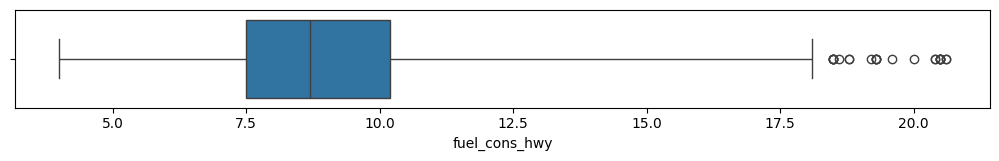

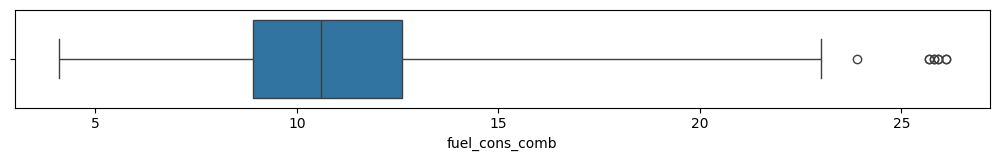

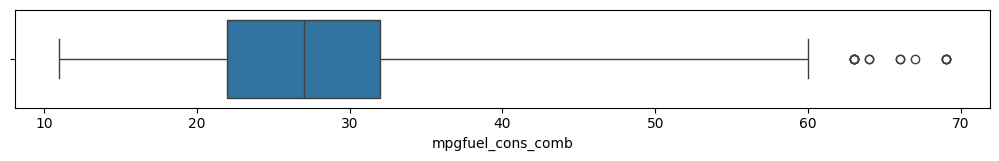

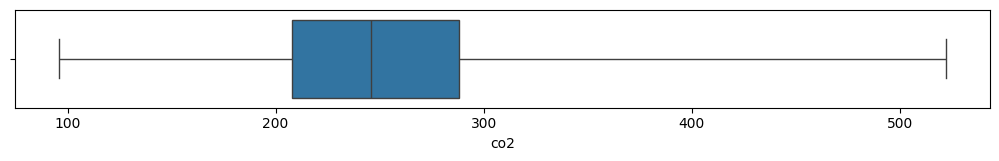

In [18]:
# Distribution of features

index=0

for feature in df.select_dtypes('number').columns:
    index+=1
    plt.figure(figsize=(20,20))
    plt.subplot((len(df.columns)),2,index)
    # Extended whis to 3 for less aggressive outlier detection
    sns.boxplot(x=feature,data=df,whis=3)

    plt.tight_layout()

    plt.show()

<Axes: xlabel='fuel_type', ylabel='co2'>

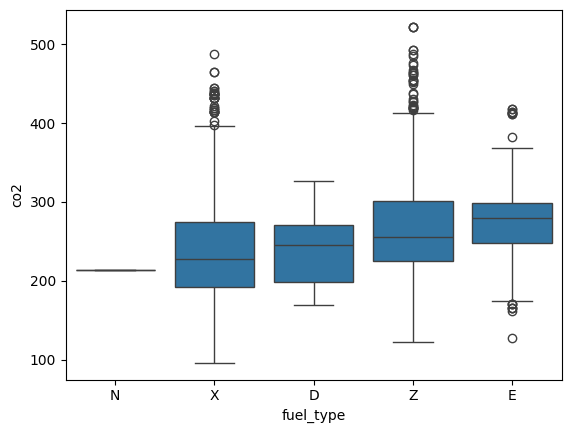

In [19]:
index_sort = df.groupby('fuel_type')['co2'].mean().sort_values().index
index_sort

sns.boxplot(x='fuel_type', y='co2', data=df, order=index_sort)

In [20]:
# Visualize variable distribution by feature

def explore_feature_distribution(x,y):

  if df[x].nunique() > 10:
      plt.figure(figsize=(15,5))
      plt.xticks(rotation=80)

  # sort the boxes using group means in ascending order if x is not numerical
  if type(df[x].iloc[1]) == str:
    index_sort = df.groupby(x)[y].mean().sort_values().index

    sns.boxplot(data = df, x = x, y = y, hue = x, whis = 3, order=index_sort)


  sns.boxplot(data = df, x = x, y = y, hue = x, whis = 3)

  plt.title(f'Distribution of {y} by {x}')
  plt.xlabel(x)
  plt.ylabel(y)

  plt.tight_layout()

  plt.show()

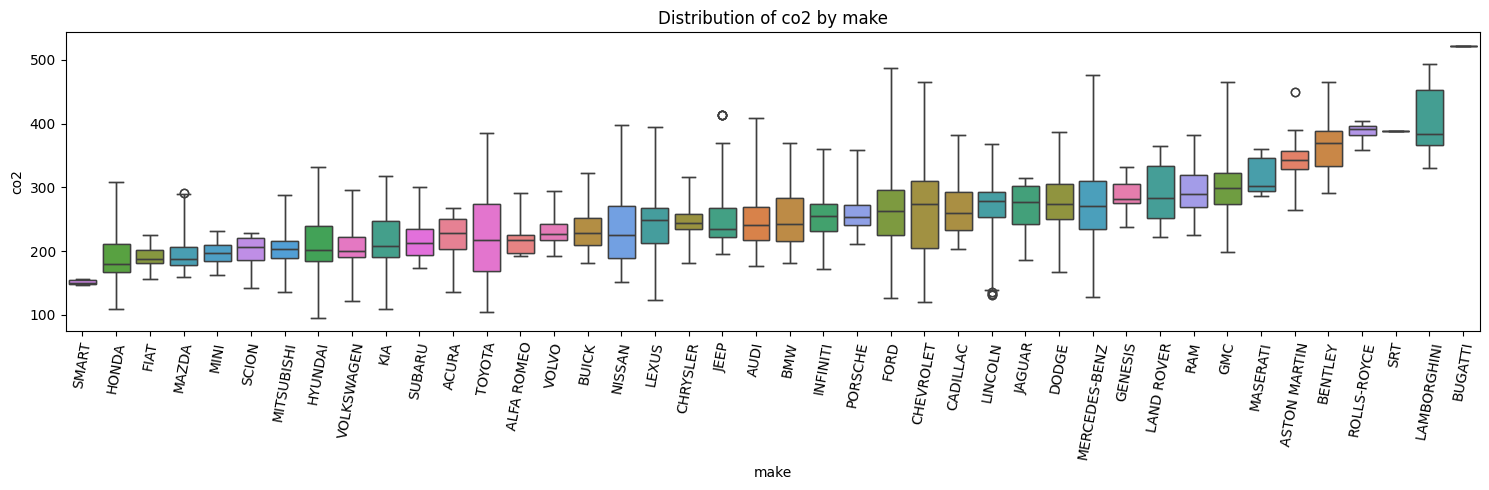

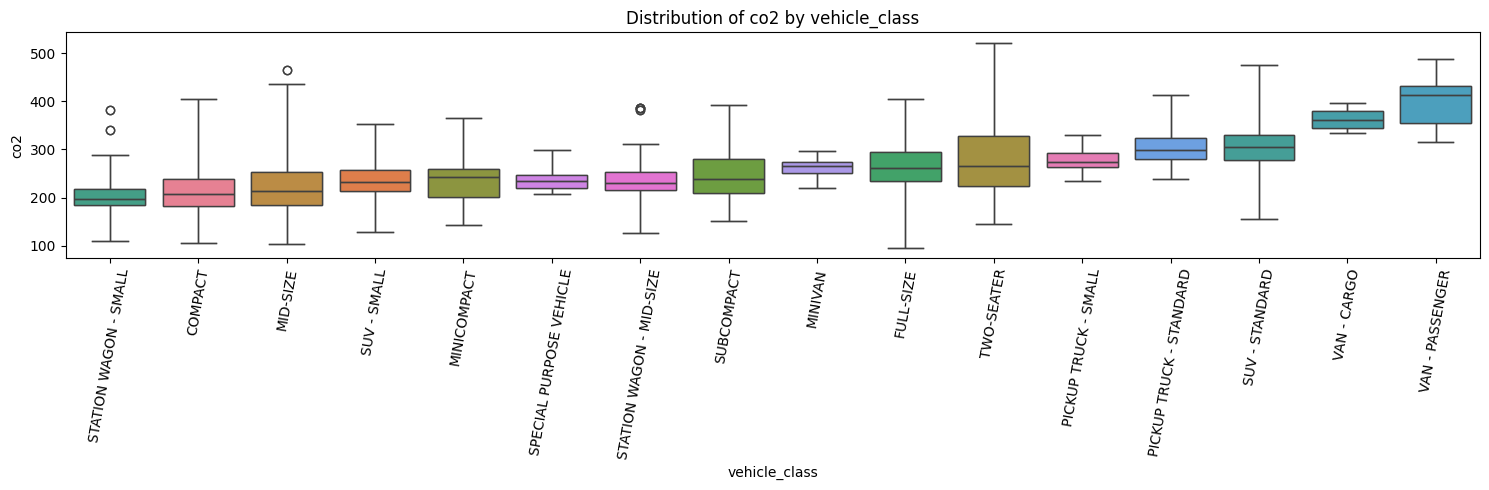

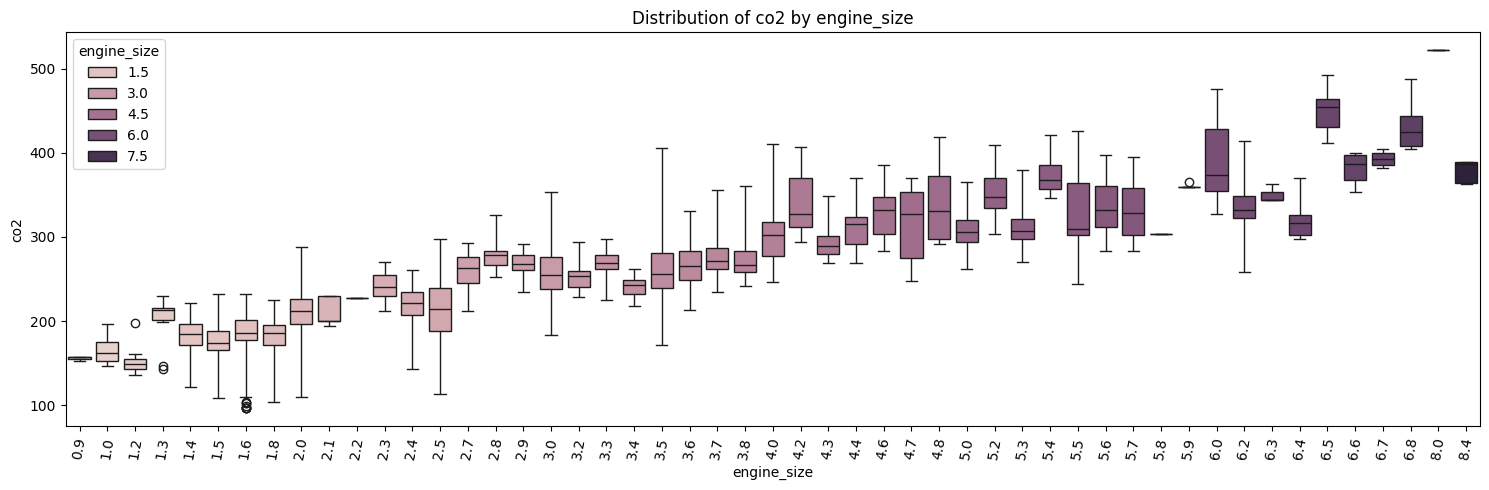

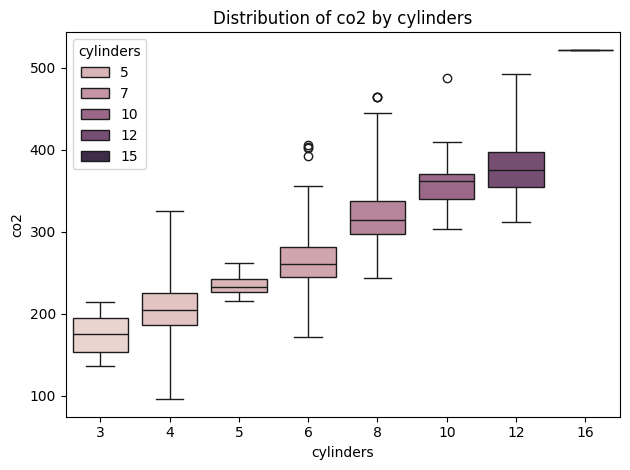

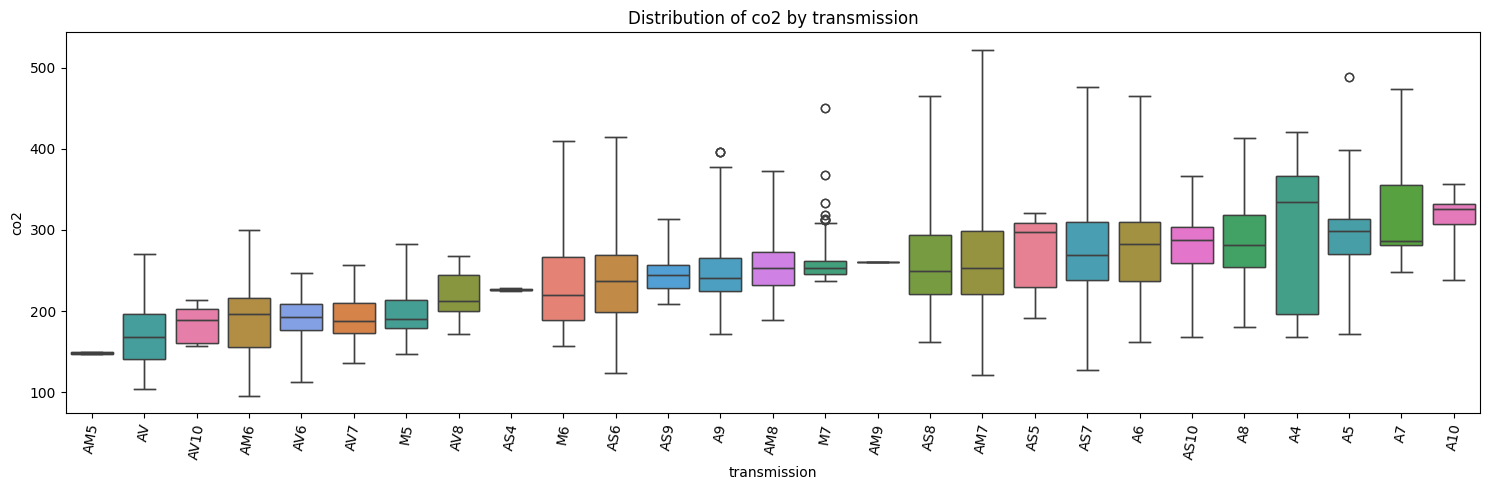

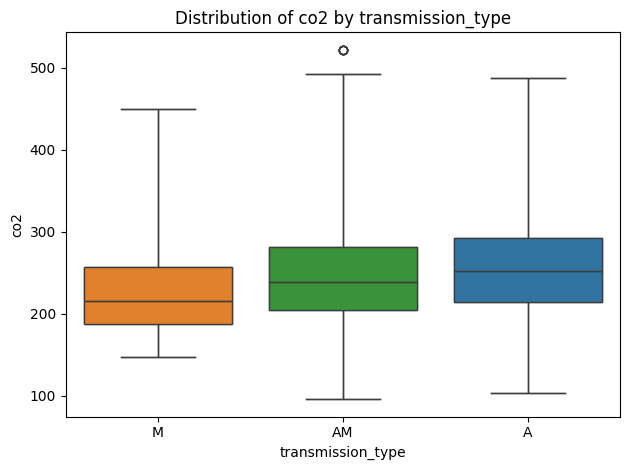

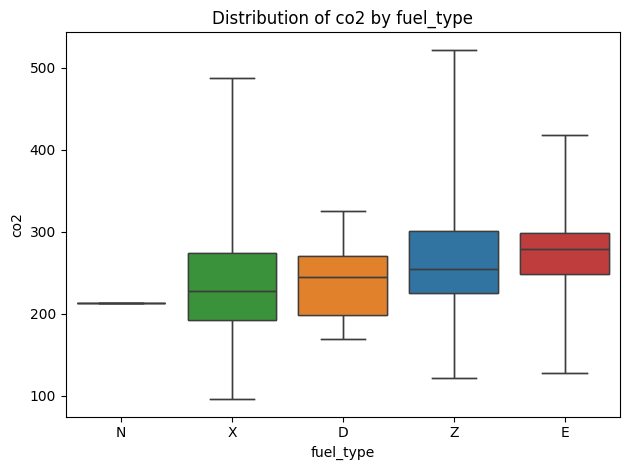

In [21]:
for x in ['make', 'vehicle_class', 'engine_size', 'cylinders', 'transmission', 'transmission_type', 'fuel_type']:

  for y in ['co2']:

    explore_feature_distribution(x,y)


## Machine Learning

### Linear Regression with One-hot Encoding

#### One-hot Encoding

In [22]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape the data and fit-transform with encoder
transmission_type_encoded = encoder.fit_transform(df['transmission_type'].values.reshape(-1, 1))

# Create a DataFrame from the encoded data
# The column names correspond to the unique values in 'transmission_type'
encoded_columns = pd.DataFrame(transmission_type_encoded, columns=encoder.get_feature_names_out(['transmission_type']))

# Concatenate the new columns to the original DataFrame
df_onehot = pd.concat([df.reset_index(drop=True), encoded_columns], axis=1)

df_onehot.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2,transmission_type,transmission_type_A,transmission_type_AM,transmission_type_M
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,A,1.0,0.0,0.0
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221,M,0.0,0.0,1.0
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136,A,1.0,0.0,0.0
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,A,1.0,0.0,0.0
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,A,1.0,0.0,0.0


#### Train-test Split

In [23]:
# Load independent and dependent variables.
X = df_onehot[['engine_size','cylinders','fuel_cons_city',	'fuel_cons_hwy', 'fuel_cons_comb','transmission_type_A', 'transmission_type_AM','transmission_type_M']]
y = df_onehot['co2']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Scale the Data

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Create and fit model

In [25]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [26]:
# Check the coeeficients
np.set_printoptions(suppress=True)
np.round(lm.coef_,2)

array([ 7.85000000e+00,  1.16800000e+01,  5.02000000e+00,  4.01000000e+00,
        2.93300000e+01, -8.27210797e+13, -5.44126383e+13, -7.02442773e+13])

Note coefficients for one-hot encoded columns.

Unecessary one-hot encoding for transmission type?

NEXT STEPS:
- encode fuel type

#### Evaluate training performance

In [27]:
y_train_pred = lm.predict(X_train)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def linear_eval(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    #print("Model testing performance:")
    print("---------------------------------------")
    print(f"R2 score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")

print("Model testing performance for TRAIN DATA:")
linear_eval(y_train, y_train_pred)

Model testing performance for TRAIN DATA:
---------------------------------------
R2 score 	: 0.8799108098371341
MAE 		: 13.41562532395299
MSE 		: 410.53102355405275
RMSE 		: 20.261565180263165


### Apply model to test data

In [29]:
y_test_pred = lm.predict(X_test)

#### Evaluate model performance

In [30]:
print("Model testing performance for TESTING DATA:")
linear_eval(y_test, y_test_pred)

Model testing performance for TESTING DATA:
---------------------------------------
R2 score 	: 0.8775330799890743
MAE 		: 13.570652820674528
MSE 		: 421.2405754430699
RMSE 		: 20.52414615624898


#### Cross-validation

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

##### k-fold

In [32]:
# k-fold Cross-validation
lm = LinearRegression()

# fit linear model
lm.fit(X_train, y_train)

R2 = cross_val_score(lm, X_train, y_train, scoring='r2', cv=10)

# Since we performed multi-linear regression, we should use adjust r-squared
# calculate adj r2
n = len(X_train)
p = len(X.columns)
adj_R2 = 1- ((1-R2) * (n-1)/(n-p-1))

# use adjusted R2 as cross validation score
print("Cross-validation results using ADJUSTED R2: \n%0.3f accuracy with a standard deviation of %0.3f" % (adj_R2.mean(), adj_R2.std()))

Cross-validation results using ADJUSTED R2: 
0.879 accuracy with a standard deviation of 0.012


##### GridSearchCV

In [33]:
from sklearn.linear_model import LinearRegression, Ridge

# Define the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Create a Ridge regression model
ridge = Ridge()

# Use GridSearchCV to perform grid search with cross-validation
grid_search = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Train the model with the best hyperparameters
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = best_ridge_model.predict(X_test)
r2 = r2_score(y_test, y_val_pred)

print(f"Best alpha: {best_alpha}")
print(f"R-squared on validation set: {r2}")

Best alpha: 10
R-squared on validation set: 0.877530586763611


### Clustering & Multinomial Regression

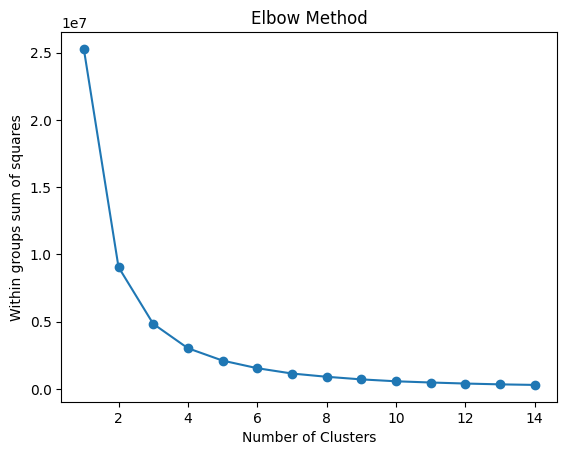

In [34]:
# Elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df['co2'] = pd.to_numeric(df['co2'], errors='coerce')

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=25, random_state=0)
    kmeans.fit(df[['co2']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within groups sum of squares')
plt.show()